# Predefined functions

In [1]:
import pandas as pd

# Getting data
def getData(url, sheet_name=0, skiprows=0, truncate=-1, index_column='County Name'):
    df = pd.read_excel(url, sheet_name=sheet_name, skiprows=skiprows)
    if truncate > -1:
        df = df.truncate(before=0, after=truncate)
    df = df.set_index(index_column)
    return df

# Data collection

## Cumulative case count

In [2]:
url = "https://dshs.texas.gov/coronavirus/TexasCOVID19DailyCountyCaseCountData.xlsx"
cases_df = getData(url, skiprows=2, truncate=254)

In [3]:
import re
from datetime import datetime
pattern = re.compile('[0-9]+-[0-9]+', re.IGNORECASE)
cases_df.columns = [pattern.findall(sub)[0] for sub in cases_df.keys()]
cases_df.columns = [datetime.strptime(date, '%m-%d') for date in cases_df.keys()]

# Plotting

In [4]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.dates as mdates

figsize=(12,8)
title_size = 24
label_size = 18
ticker_count= 8
line_width = 2.5

## 7-day average daily case count

C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


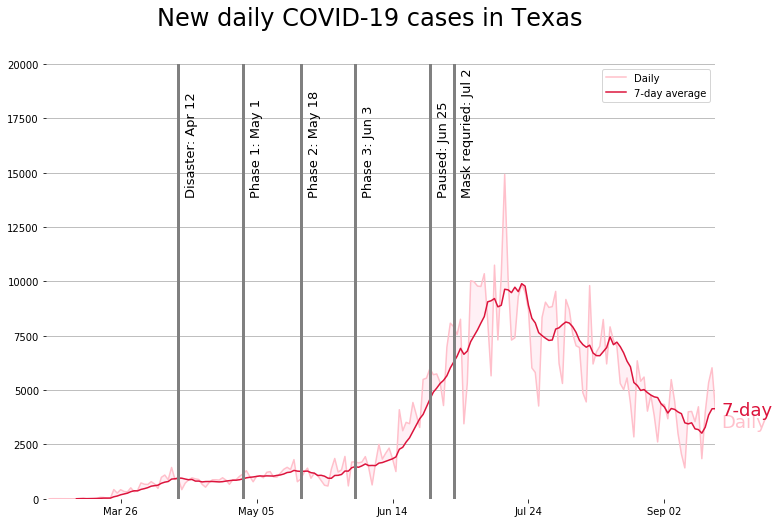

In [5]:
import seaborn as sns
from datetime import datetime, timedelta

# create figure
fig, ax = plt.subplots(figsize=figsize)
fig.suptitle('New daily COVID-19 cases in Texas', fontsize=title_size)

data = cases_df.loc['Total']
ylim = 20000
# new daily case
daily = data.diff()
sns.lineplot(label="Daily", data=daily, ci=None, color='pink', ax=ax)
# 7-day rolling average
avg7day = daily.rolling(window=7).mean()
g = sns.lineplot(label="7-day average", data=avg7day, color='crimson')

# major events
events = {'Disaster':'Apr 12', 'Phase 1':'May 1', 'Phase 2':'May 18', 'Phase 3':'Jun 3', 'Paused':'Jun 25', 'Mask requried':'Jul 2'}
for event, date in events.items():
    date_obj = datetime.strptime(date, '%b %d')
    plt.axvline(date_obj, color='gray', linewidth=3)
    plt.text(date_obj + timedelta(days=2), ylim*0.7, event + ': ' + date, rotation=90, fontsize=13)

# fill between 2 lines
ax.fill_between(data.keys(), daily, avg7day, facecolor='lavenderblush')
    
# legend
g.legend(loc='upper right')
    
# ylim
ax.set_xlim(cases_df.keys()[0], cases_df.keys()[-15])
ax.set_ylim(0, ylim)

# horizontal grid lines
ax.yaxis.grid(True)

# remove outer frame
plt.box(on=None)

# number of tickers
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
# ticker formatter
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))

# configure legend on lines
for line, name in zip(ax.lines, ['Daily', '7-day']):
    y = line.get_ydata()[-1]
    ax.annotate(name, xy=(1,y), xytext=(6,0), color=line.get_color(), 
                xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                size=18, va="center")

fig.savefig('../graphs/hypothesis_3.png')

# Statistical testing

In [6]:
import numpy as np

test_df = cases_df.T.copy().diff().replace(np.nan, 0)

# class into 4 tie period for test 

# rate1 before 05-01
r1 = test_df.iloc[0:55]
test_df['rate1'] = r1['Total']/28995881

# rate2 between 05-01 to 06-02
r2 = test_df.iloc[55:88]
test_df['rate2'] = r2['Total']/28995881

# rate3 between 06-03 to 07-02
r3 = test_df.iloc[88:118]
test_df['rate3'] = r3['Total']/28995881

# rate4 after 07-02
r4 = test_df.iloc[118:]
test_df['rate4'] = r4['Total']/28995881
test_df = test_df.replace(np.nan, 0)
#test_df

## Paired T-test

In [7]:
# paired tests 
from scipy import stats
print(stats.ttest_rel(test_df['rate1'], test_df['rate2'])) 
print(stats.ttest_rel(test_df['rate2'], test_df['rate3']))
print(stats.ttest_rel(test_df['rate2'], test_df['rate4']))

Ttest_relResult(statistic=-1.2317282135262877, pvalue=0.2194413295918633)
Ttest_relResult(statistic=-3.021232257111294, pvalue=0.0028332399746599703)
Ttest_relResult(statistic=-9.711234781993303, pvalue=1.2667782312900492e-18)


# Z-test

In [8]:
# z-test
from statsmodels.stats import weightstats as stets
stets.ztest(test_df['rate3'], test_df['rate2'], value=0, alternative='two-sided')

(3.1387011204601736, 0.0016969843685233142)

# ANOVA

In [9]:
# ANOVA
stats.f_oneway(test_df['rate2'], test_df['rate3'])

F_onewayResult(statistic=9.851444723577957, pvalue=0.0018178488482932268)